# Scan of  Fitsskyflats Files of Monocam
================================================================

- Date of creation : Sunday 5th 2016
- Author : Sylvie Dagoret-Campagne
- Affiliation : LAL/IN2P3/CNRS

In [46]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [47]:
from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
import os
import ccdproc

In [48]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import pytz

## 1) Configuration of input files

### 1.1) The input skyflat files

In [49]:
# skyflats at the beginning
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
root_filename='skyflats_'
ext_filename='.fits'
startnum=1
stopnum=40

date=datetime(2016,5,9)  # 2016-05-10T01:07:55.503
nb_of_channels=16  # number of CCD amplifier channels corresponding to an image inside the fits file

In [50]:
# the bias master file
masterbias_filename='masterbias1.fits'
masterbias_file=os.path.join(path,masterbias_filename)

In [51]:
def Buildfilename(path,name,ext,num):
    '''
    input:
       path : path of bias files
       name : common root of bias filenames
       ext  : extension of filenames
    output:
       full filename 
    '''
    strnum= '{0:02d}'.format(num)  # python >= 2.6
    filename=name+strnum+ext
    fullfilename=os.path.join(path,filename)
    return fullfilename

In [52]:
filelist= [Buildfilename(path,root_filename,ext_filename,num) for num in range(startnum,stopnum+1,1)]

In [53]:
nbfiles=len(filelist)

### 1.2) configuration of date

In [54]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-06 21:46:55.463671
fits date format for the analysis :  2016-06-06T21:46:55


## 2) Exposure

- compute the mean and RMS of the darks for all the pixels

In [55]:
NBCHAN=16
NBFILES=nbfiles

# arrays initialisation
means0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms0=np.zeros((NBCHAN,NBFILES),dtype=np.float)
means=np.zeros((NBCHAN,NBFILES),dtype=np.float)
rms=np.zeros((NBCHAN,NBFILES),dtype=np.float)

list_exposures=np.zeros(NBFILES,dtype=np.float)

# loop on files
for file in range(0,nbfiles):
    hdu_list = fits.open(filelist[file])
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    list_exposures[file]=exposure
    # loop on channels
    for numchan in range(1,number_of_channels+1):
        image_data = hdu_list[numchan].data
        nrow,ncol =image_data.shape
        # extract the two quatities
        firstcol = image_data[:,0]
        othercol = image_data[:,1:ncol]
        # flatten the arrays
        lowvalue = firstcol.flatten()
        highvalue = othercol.flatten()
        # extract mean and rms
        means0[numchan-1,file]=lowvalue.mean()
        rms0[numchan-1,file]=lowvalue.std()
        means[numchan-1,file]=highvalue.mean()
        rms[numchan-1,file]=highvalue.std()        
                

In [56]:
list_exposures

array([  2.,   2.,   4.,   4.,   4.,   3.,   6.,   8.,  10.,  10.,  10.,
         5.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   6.,   6.,   6.,   6.,   8.,   6.,   9.,   9.,   9.,   9.,
        11.,  10.,  10.,  10.,  10.,  10.,  10.])

In [57]:
for file in range(0,nbfiles):
    print file,')',os.path.basename(filelist[file]), ':: exposures=',list_exposures[file],'seconds'

0 ) skyflats_01.fits :: exposures= 2.0 seconds
1 ) skyflats_02.fits :: exposures= 2.0 seconds
2 ) skyflats_03.fits :: exposures= 4.0 seconds
3 ) skyflats_04.fits :: exposures= 4.0 seconds
4 ) skyflats_05.fits :: exposures= 4.0 seconds
5 ) skyflats_06.fits :: exposures= 3.0 seconds
6 ) skyflats_07.fits :: exposures= 6.0 seconds
7 ) skyflats_08.fits :: exposures= 8.0 seconds
8 ) skyflats_09.fits :: exposures= 10.0 seconds
9 ) skyflats_10.fits :: exposures= 10.0 seconds
10 ) skyflats_11.fits :: exposures= 10.0 seconds
11 ) skyflats_12.fits :: exposures= 5.0 seconds
12 ) skyflats_13.fits :: exposures= 3.0 seconds
13 ) skyflats_14.fits :: exposures= 3.0 seconds
14 ) skyflats_15.fits :: exposures= 3.0 seconds
15 ) skyflats_16.fits :: exposures= 3.0 seconds
16 ) skyflats_17.fits :: exposures= 3.0 seconds
17 ) skyflats_18.fits :: exposures= 3.0 seconds
18 ) skyflats_19.fits :: exposures= 3.0 seconds
19 ) skyflats_20.fits :: exposures= 3.0 seconds
20 ) skyflats_21.fits :: exposures= 3.0 seconds

### 2.1) Show exposure versus time

-exposure recorded in fits header file

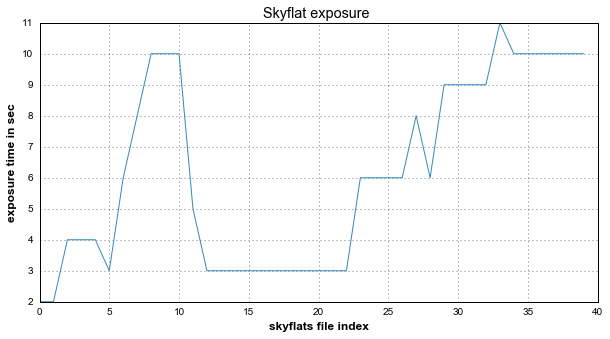

In [58]:
title='Skyflat exposure '
fig = plt.figure(figsize=(10,5))
plt.plot(range(NBFILES),list_exposures)    
plt.title(title)
plt.xlabel('skyflats file index')
plt.ylabel('exposure time in sec')
plt.grid(True)
plt.savefig('scan_skyflat_exposure.pdf', bbox_inches='tight')

### 2.2) skyflat versus time

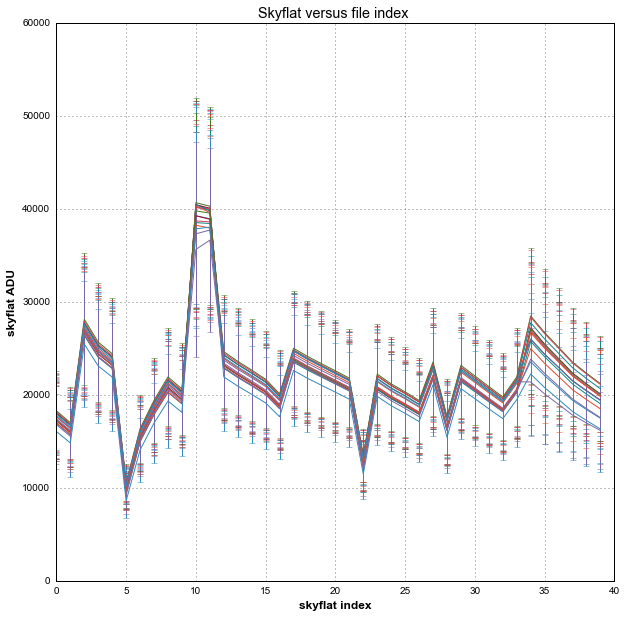

In [59]:
title='Skyflat versus file index '
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:])
    
plt.title(title)
plt.xlabel('skyflat index')
plt.ylabel('skyflat ADU')
plt.grid(True)
plt.savefig('scan_skyflat_time.pdf', bbox_inches='tight')

### 2.3) Skyflats versus index in each amplifier

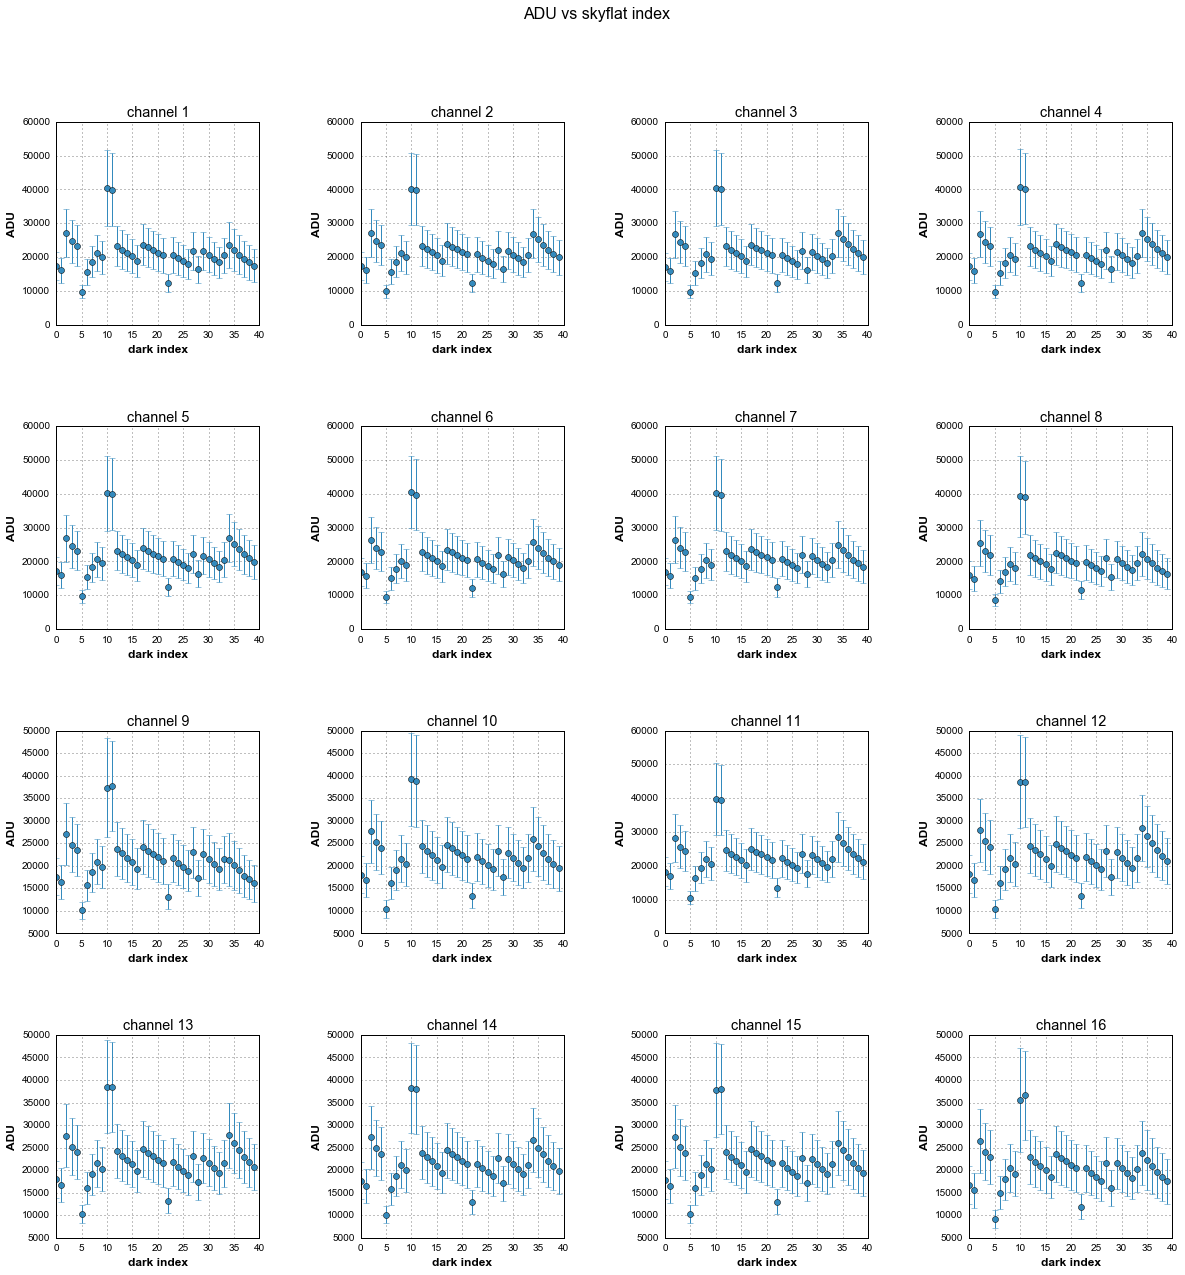

In [60]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
    numchan=index
    axarr[iy,ix].errorbar(range(NBFILES),means[numchan,:],yerr=rms[numchan,:],fmt='o')
    plottitle='channel {}'.format(index+1)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('flat index')
    axarr[iy,ix].grid(True)

title='ADU vs skyflat index'
plt.suptitle(title,size=16)
plt.show()


### 2.4) skyflat In Biassec

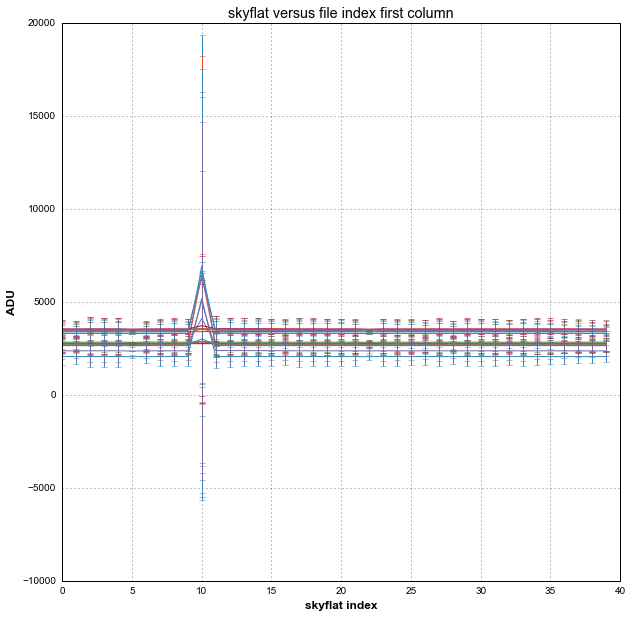

In [61]:
title='skyflat versus file index first column'
fig = plt.figure(figsize=(10,10))
for numchan in range(0,number_of_channels):
    plt.errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:])
    
plt.title(title)
plt.xlabel('skyflat index')
plt.ylabel('ADU')
plt.grid(True)

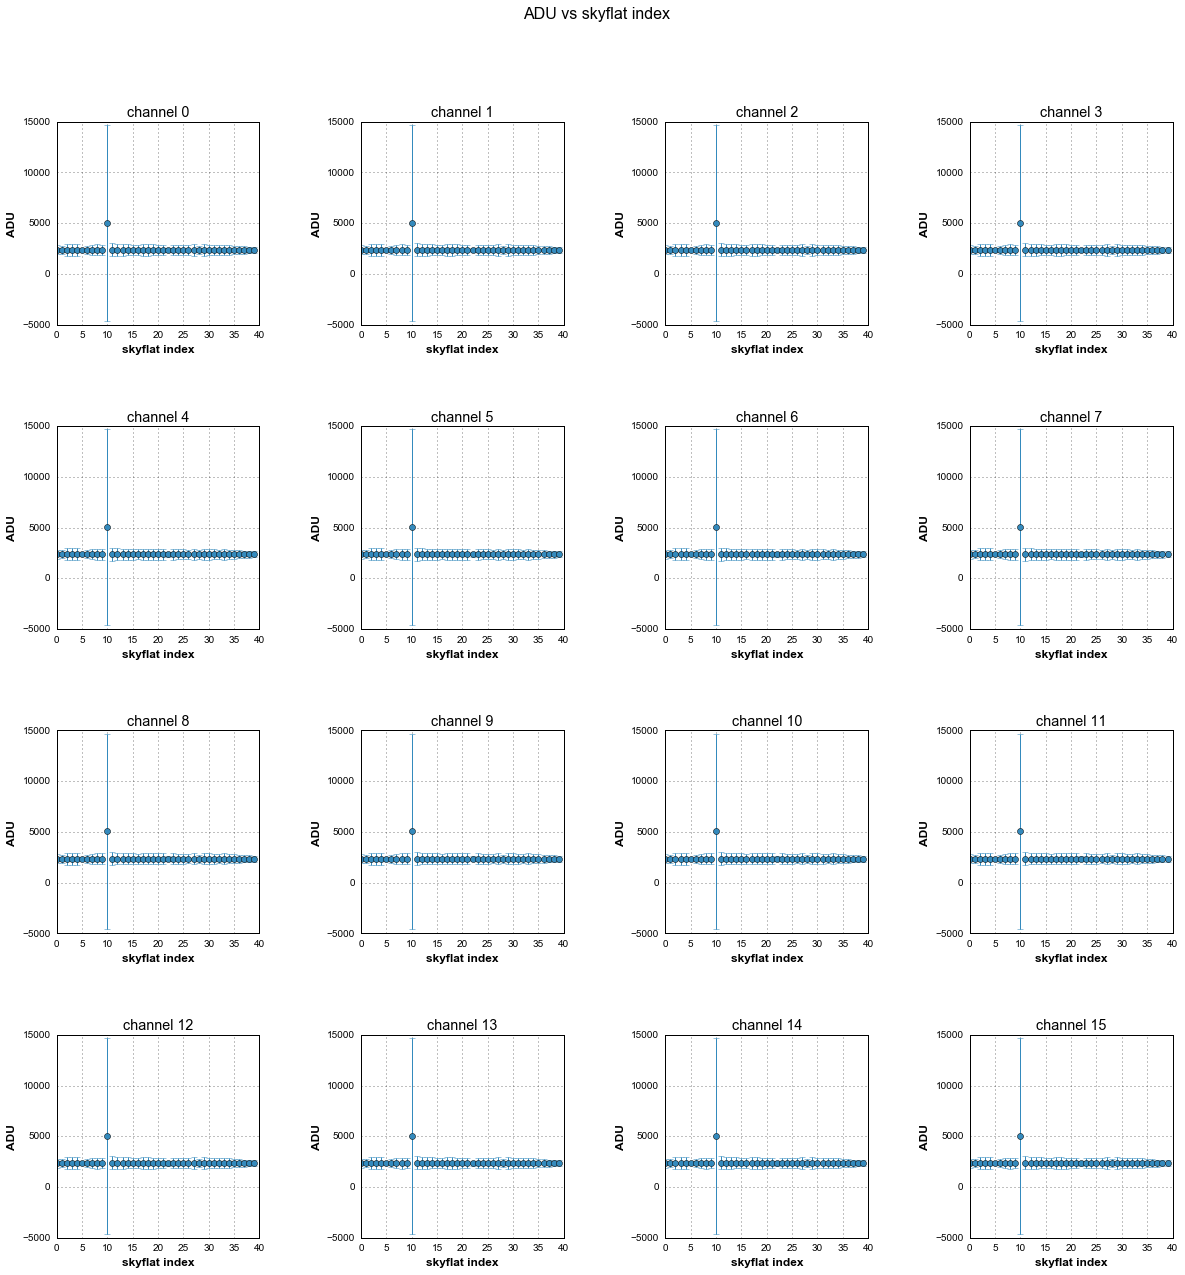

In [62]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
        
    axarr[iy,ix].errorbar(range(NBFILES),means0[numchan,:],yerr=rms0[numchan,:],fmt='o')
    plottitle='channel {}'.format(index)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('skyflat index')
    axarr[iy,ix].grid(True)
    
title='ADU vs skyflat index'
plt.suptitle(title,size=16)
plt.show()

## 3) Substraction of Master Bias to the Skyflat

### 3.1 Read All Master-Biases

In [63]:
masterbiases = [ ccdproc.CCDData.read(masterbias_file, hdu=chan,unit="adu") for chan in range(1,nb_of_channels+1,1) ]

### 3.2 Put all darks inside a list of CCDDATA list

In [64]:
# all CCDPROC data collector : each channel as a list of dark data
allskyflats = []

In [65]:
for chan in range(1,nb_of_channels+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in filelist ]
    allskyflats.append(ccd_chan)

### 3.3 Substract the masterbias to the Darks 

In [66]:
mbias_and_flats=zip(masterbiases, allskyflats)

In [67]:
list_subskyflats= []  # list of list of substracted darks, one list per channel
for mb, sflats in mbias_and_flats:
    list_sf=[]      # list of substracted darks for the current channel
    for sf in sflats:
        s=ccdproc.subtract_bias(sf,mb)
        list_sf.append(s)
    list_subskyflats.append(list_sf)   

## 4) Show the Sky Flat versus Exposure

### 4.1) Compute the average dark

In [68]:
# book the arrays in advance

newmeans=np.zeros((NBCHAN,NBFILES),dtype=np.float)
newrms=np.zeros((NBCHAN,NBFILES),dtype=np.float)
newexpo=np.zeros((NBCHAN,NBFILES),dtype=np.float)

for fileindex in range(0,nbfiles):
    Xpos=list_exposures[fileindex]
    for channel in range(0,nb_of_channels):       
        newmeans[channel,fileindex]=list_subskyflats[channel][fileindex].data.mean()
        newrms[channel,fileindex]=list_subskyflats[channel][fileindex].data.std()
        newexpo[channel,fileindex]=Xpos

### 4.2) Plot Skyflat vs Exposure for each channels

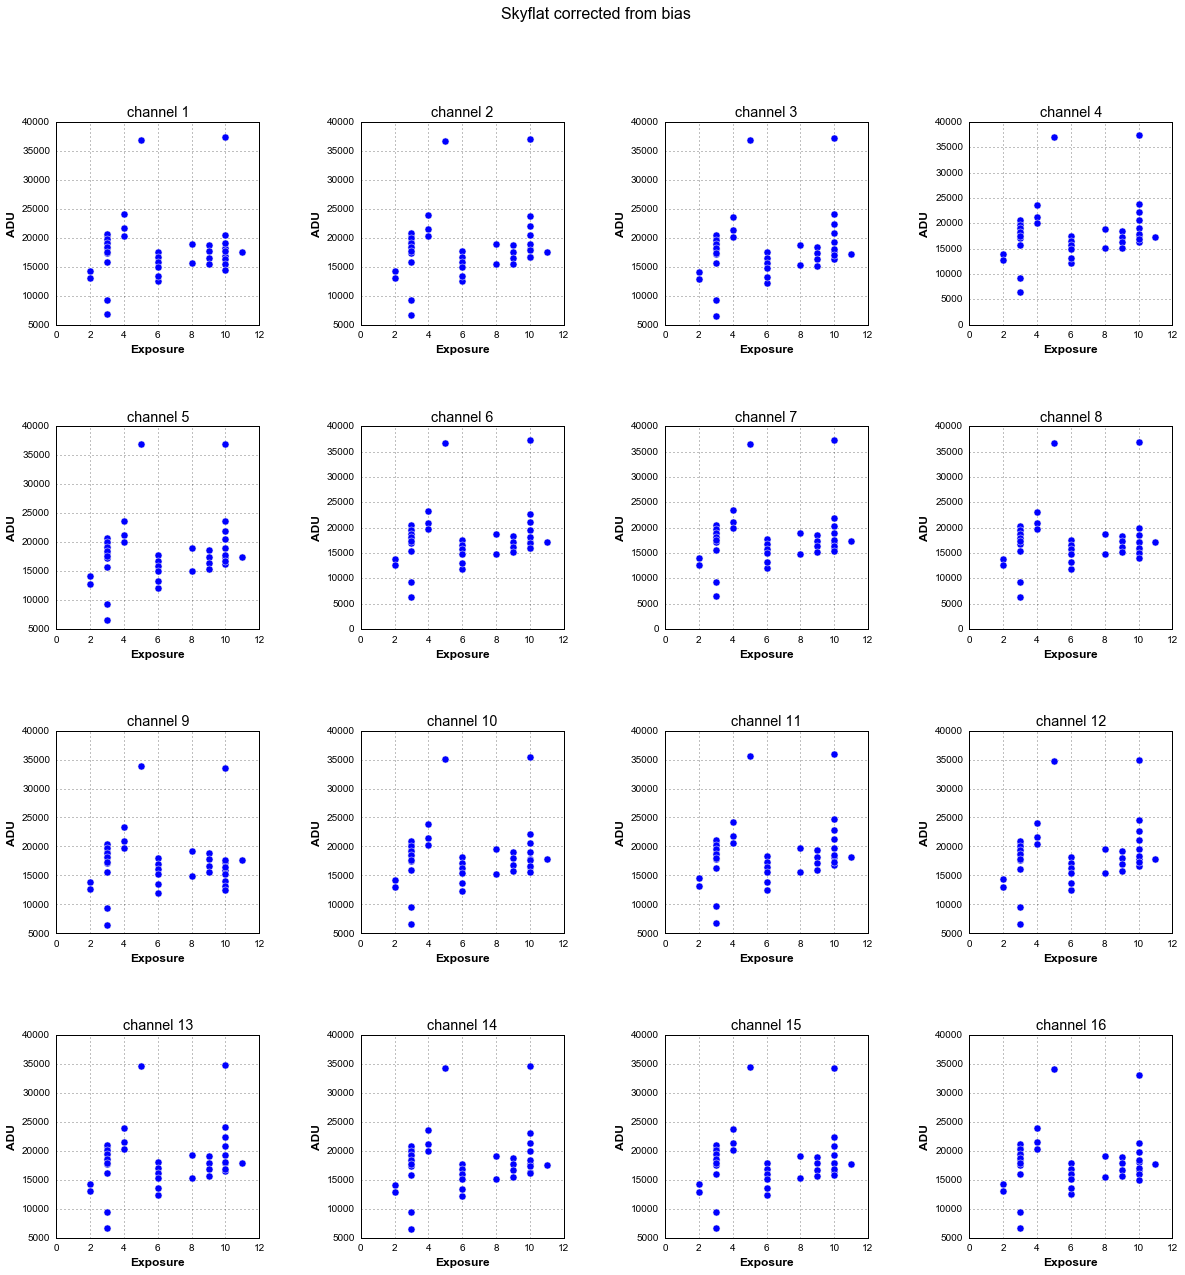

In [69]:
NX=4 # number of images along the horizontal axis
NY=4 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
#f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
f.subplots_adjust(hspace=0.5,wspace=0.5)

for index in range(0,number_of_channels):  
    ix=index%4
    iy=index/4
    numchan=index
    axarr[iy,ix].scatter(newexpo[numchan,:],newmeans[numchan,:],s=50,marker='o')
    plottitle='channel {}'.format(index+1)
    axarr[iy,ix].set_title(plottitle)
    axarr[iy,ix].set_ylabel('ADU')
    axarr[iy,ix].set_xlabel('Exposure')
    axarr[iy,ix].grid(True)

title='Skyflat corrected from bias'
plt.suptitle(title,size=16)
plt.show()

### 4.3) Plot skyflat vs Exposure all channels 

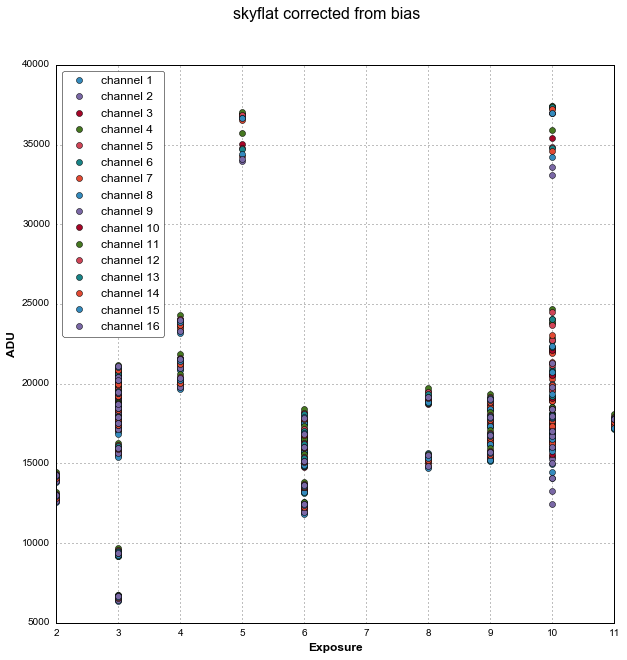

In [70]:
NX=1 # number of images along the horizontal axis
NY=1 # number of images along the vertical axis
f, axarr = plt.subplots(NY,NX,figsize=(10,10)) # figure organisation

for index in range(0,number_of_channels):      
    numchan=index
    lab='channel {}'.format(index+1)
    plt.plot(newexpo[numchan,:],newmeans[numchan,:],'o',label=lab)
    
plt.ylabel('ADU')
plt.xlabel('Exposure')
plt.grid(True)
plt.legend(loc='best')

title='skyflat corrected from bias'
plt.suptitle(title,size=16)
plt.show()